
# Oscillator and ADSR envelope

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to synthesize various waveforms using
:py:func:`~torchaudio.prototype.functional.oscillator_bank` and
:py:func:`~torchaudio.prototype.functional.adsr_envelope`.

<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial requires prototype DSP features, which are
   available in nightly builds.

   Please refer to https://pytorch.org/get-started/locally
   for instructions for installing a nightly build.</p></div>


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.3.0.dev20240222
2.2.0.dev20240222


In [2]:
try:
    from torchaudio.prototype.functional import adsr_envelope, oscillator_bank
except ModuleNotFoundError:
    print(
        "Failed to import prototype DSP features. "
        "Please install torchaudio nightly builds. "
        "Please refer to https://pytorch.org/get-started/locally "
        "for instructions to install a nightly build."
    )
    raise

import math

import matplotlib.pyplot as plt
from IPython.display import Audio

PI = torch.pi
PI2 = 2 * torch.pi

## Oscillator Bank

Sinusoidal oscillator generates sinusoidal waveforms from given
amplitudes and frequencies.

\begin{align}x_t = A_t \sin \theta_t\end{align}

Where the phase $\theta_t$ is found by integrating the instantaneous
frequency $f_t$.

\begin{align}\theta_t = \sum_{k=1}^{t} f_k\end{align}

<div class="alert alert-info"><h4>Note</h4><p>Why integrate the frequencies? Instantaneous frequency represents the velocity
   of oscillation at given time. So integrating the instantaneous frequency gives
   the displacement of the phase of the oscillation, since the start.
   In discrete-time signal processing, integration becomes accumulation.
   In PyTorch, accumulation can be computed using :py:func:`torch.cumsum`.</p></div>

:py:func:`torchaudio.prototype.functional.oscillator_bank` generates a bank of
sinsuoidal waveforms from amplitude envelopes and instantaneous frequencies.




### Simple Sine Wave

Let's start with simple case.

First, we generate sinusoidal wave that has constant frequency and
amplitude everywhere, that is, a regular sine wave.




We define some constants and helper function that we use for
the rest of the tutorial.




In [3]:
F0 = 344.0  # fundamental frequency
DURATION = 1.1  # [seconds]
SAMPLE_RATE = 16_000  # [Hz]

NUM_FRAMES = int(DURATION * SAMPLE_RATE)

In [4]:
def show(freq, amp, waveform, sample_rate, zoom=None, vol=0.3):
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(4, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title=f"Oscillator bank (bank size: {amp.size(-1)})", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, amp.numpy())
    axes[1].set(ylabel="Amplitude", ylim=[-0.03 if torch.all(amp >= 0.0) else None, None])
    axes[2].plot(t, waveform.numpy())
    axes[2].set(ylabel="Waveform")
    axes[3].specgram(waveform, Fs=sample_rate)
    axes[3].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(4):
        axes[i].grid(True)
    pos = axes[2].get_position()
    plt.tight_layout()

    if zoom is not None:
        ax = fig.add_axes([pos.x0 + 0.01, pos.y0 + 0.03, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=zoom, xticks=[], yticks=[])

    waveform /= waveform.abs().max()
    return Audio(vol * waveform, rate=sample_rate, normalize=False)

Now we synthesize the audio with constant frequency and amplitude




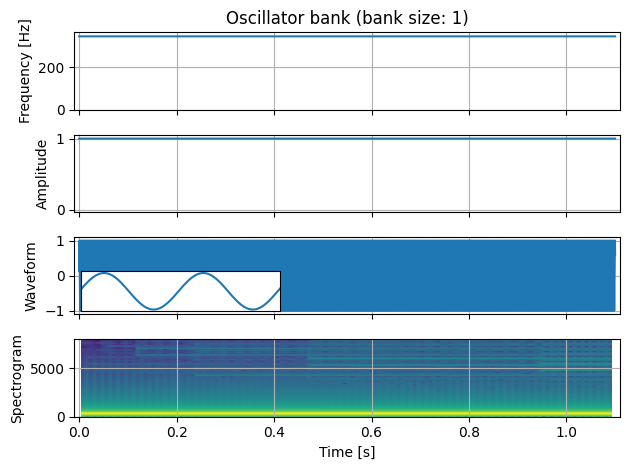

In [5]:
freq = torch.full((NUM_FRAMES, 1), F0)
amp = torch.ones((NUM_FRAMES, 1))

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

### Combining multiple sine waves

:py:func:`~torchaudio.prototype.functional.oscillator_bank` can
combine an arbitrary number of sinusoids to generate a waveform.




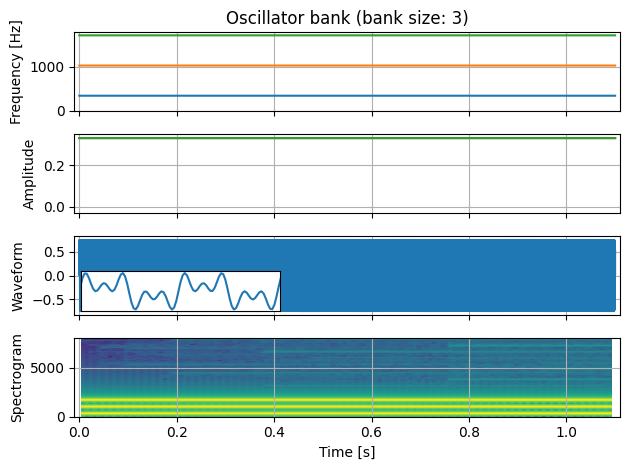

In [6]:
freq = torch.empty((NUM_FRAMES, 3))
freq[:, 0] = F0
freq[:, 1] = 3 * F0
freq[:, 2] = 5 * F0

amp = torch.ones((NUM_FRAMES, 3)) / 3

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, waveform, SAMPLE_RATE, zoom=(1 / F0, 3 / F0))

### Changing Frequencies across time

Let's change the frequency over time. Here, we change the frequency
from zero to the Nyquist frequency (half of the sample rate) in
log-scale so that it is easy to see the change in waveform.




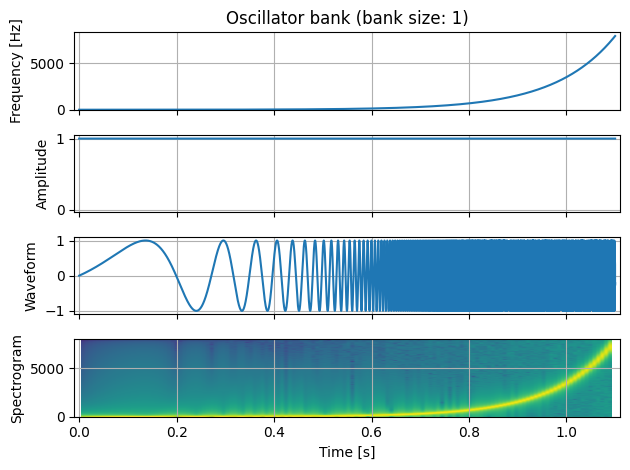

In [7]:
nyquist_freq = SAMPLE_RATE / 2
freq = torch.logspace(0, math.log(0.99 * nyquist_freq, 10), NUM_FRAMES).unsqueeze(-1)
amp = torch.ones((NUM_FRAMES, 1))

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, waveform, SAMPLE_RATE, vol=0.2)

We can also oscillate frequency.




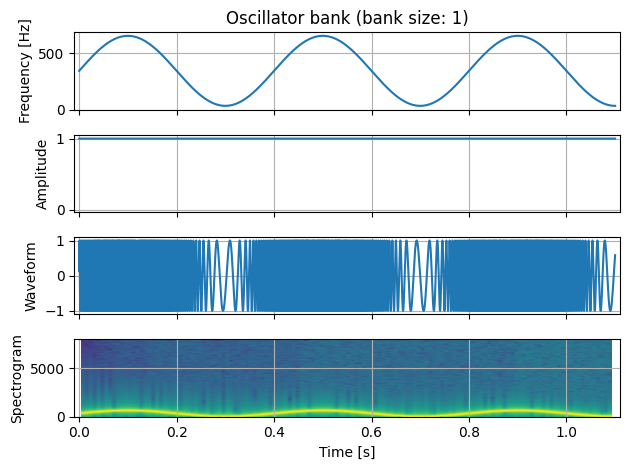

In [8]:
fm = 2.5  # rate at which the frequency oscillates
f_dev = 0.9 * F0  # the degree of frequency oscillation

freq = F0 + f_dev * torch.sin(torch.linspace(0, fm * PI2 * DURATION, NUM_FRAMES))
freq = freq.unsqueeze(-1)

amp = torch.ones((NUM_FRAMES, 1))

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, waveform, SAMPLE_RATE)

## ADSR Envelope




Next, we change the amplitude over time. A common technique to model
amplitude is ADSR Envelope.

ADSR stands for Attack, Decay, Sustain, and Release.

 - `Attack` is the time it takes to reach from zero to the top level.
 - `Decay` is the time it takes from the top to reach sustain level.
 - `Sustain` is the level at which the level stays constant.
 - `Release` is the time it takes to drop to zero from sustain level.

There are many variants of ADSR model, additionally, some models have
the following properties

 - `Hold`: The time the level stays at the top level after attack.
 - non-linear decay/release: The decay and release take non-linear change.

:py:class:`~torchaudio.prototype.functional.adsr_envelope` supports
hold and polynomial decay.




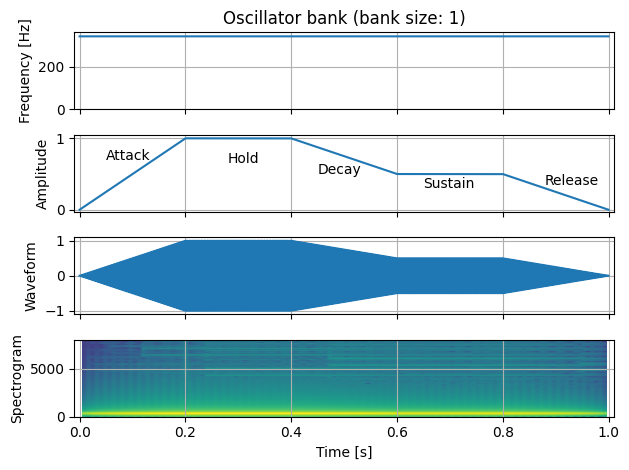

In [9]:
freq = torch.full((SAMPLE_RATE, 1), F0)
amp = adsr_envelope(
    SAMPLE_RATE,
    attack=0.2,
    hold=0.2,
    decay=0.2,
    sustain=0.5,
    release=0.2,
    n_decay=1,
)
amp = amp.unsqueeze(-1)

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

audio = show(freq, amp, waveform, SAMPLE_RATE)
ax = plt.gcf().axes[1]
ax.annotate("Attack", xy=(0.05, 0.7))
ax.annotate("Hold", xy=(0.28, 0.65))
ax.annotate("Decay", xy=(0.45, 0.5))
ax.annotate("Sustain", xy=(0.65, 0.3))
ax.annotate("Release", xy=(0.88, 0.35))
audio

Now let's look into some examples of how ADSR envelope can be used
to create different sounds.

The following examples are inspired by
[this article](https://www.edmprod.com/adsr-envelopes/)_.




### Drum Beats




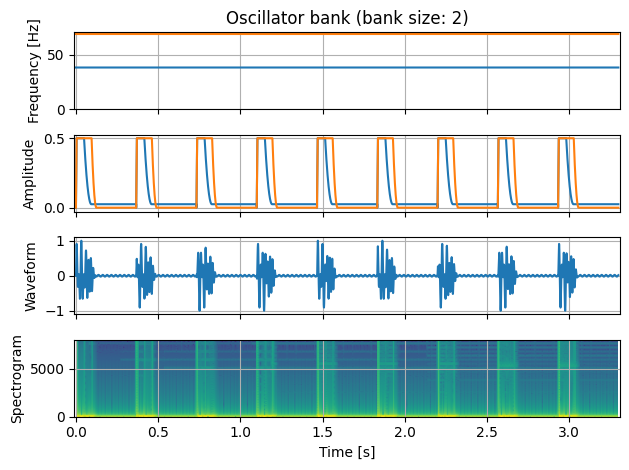

In [10]:
unit = NUM_FRAMES // 3
repeat = 9

freq = torch.empty((unit * repeat, 2))
freq[:, 0] = F0 / 9
freq[:, 1] = F0 / 5

amp = torch.stack(
    (
        adsr_envelope(unit, attack=0.01, hold=0.125, decay=0.12, sustain=0.05, release=0),
        adsr_envelope(unit, attack=0.01, hold=0.25, decay=0.08, sustain=0, release=0),
    ),
    dim=-1,
)
amp = amp.repeat(repeat, 1) / 2

bass = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, bass, SAMPLE_RATE, vol=0.5)

### Pluck




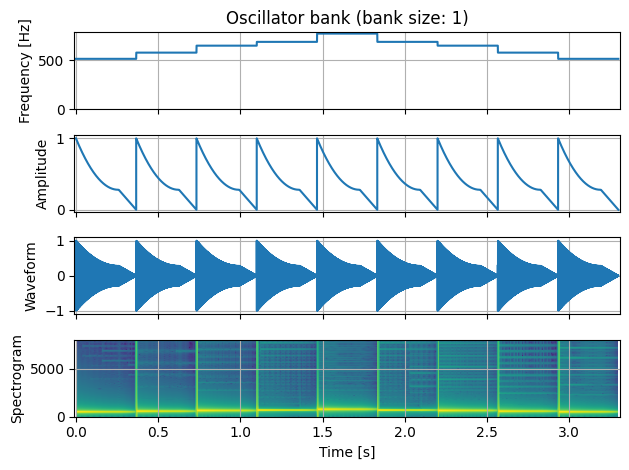

In [11]:
tones = [
    513.74,  # do
    576.65,  # re
    647.27,  # mi
    685.76,  # fa
    769.74,  # so
    685.76,  # fa
    647.27,  # mi
    576.65,  # re
    513.74,  # do
]

freq = torch.cat([torch.full((unit, 1), tone) for tone in tones], dim=0)
amp = adsr_envelope(unit, attack=0, decay=0.7, sustain=0.28, release=0.29)
amp = amp.repeat(9).unsqueeze(-1)

doremi = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, doremi, SAMPLE_RATE)

### Riser




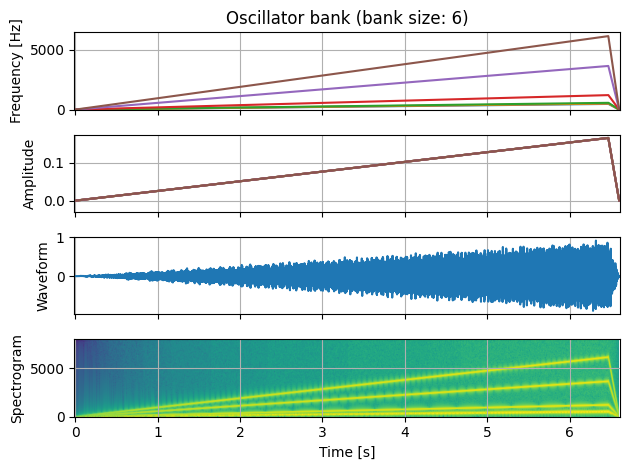

In [12]:
env = adsr_envelope(NUM_FRAMES * 6, attack=0.98, decay=0.0, sustain=1, release=0.02)

tones = [
    484.90,  # B4
    513.74,  # C5
    576.65,  # D5
    1221.88,  # D#6/Eb6
    3661.50,  # A#7/Bb7
    6157.89,  # G8
]
freq = torch.stack([f * env for f in tones], dim=-1)

amp = env.unsqueeze(-1).expand(freq.shape) / len(tones)

waveform = oscillator_bank(freq, amp, sample_rate=SAMPLE_RATE)

show(freq, amp, waveform, SAMPLE_RATE)

## References

- https://www.edmprod.com/adsr-envelopes/
- https://pages.mtu.edu/~suits/notefreq432.html
- https://alijamieson.co.uk/2021/12/19/forgive-me-lord-for-i-have-synth-a-guide-to-subtractive-synthesis/

